# <center> Planteamiento 1
El  primer  planteamiento  utiliza  la  función  de  pérdida  de  mínimos  cuadrados, incluyendo  las condiciones de frontera directamente en la función de pérdida. Esto significa que la función de pérdida calcula tanto el error de la ecuación diferencial parcial (PDE) como el error de las condiciones de frontera.

$$
\mathcal{L}(u_{NN}) = \frac{1}{N} \sum_{i=1}^{N} \left( -\Delta u_{NN}(x_i) + \alpha u_{NN}(x_i) - f(x_i) \right)^2
+ \lambda_1 \left( u_{NN}(0) - g(0) \right)^2
+ \lambda_2 \left( u_{NN}(1) - g(1) \right)^2
$$

En donde $\lambda_1$ y $\lambda_2$ son parámetros.

In [2]:
# pip install keras-core

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras

keras.utils.set_random_seed(1234)
dtype = 'float32'
keras.backend.set_floatx(dtype)

alpha = 0
limInf = 0
limSup = np.pi

neurons = 6
nLayers = 4
nPts = 500
iterations = 500

lambda0 = 2
lambda1 = 5
lambda2 = 8

def makeModel1(neurons, nLayers, activation):
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xVals)
    for l in range(nLayers - 2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)
    uModel = keras.Model(inputs=xVals, outputs=output, name='u_model')
    return uModel

class Loss1(keras.layers.Layer):
    def __init__(self, uModel, nPts, f, lambda0=1, lambda1=1, lambda2=1, limInf=0, limSup=np.pi, **kwargs):
        super(Loss1, self).__init__()
        self.uModel = uModel
        self.nPts = nPts
        self.f = f
        self.lambda0 = lambda0
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.limInf = limInf
        self.limSup = limSup

    def call(self, inputs):
        x = tf.random.uniform([self.nPts], self.limInf, self.limSup, dtype=dtype)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.uModel(x, training=True)
            dux = t2.gradient(u, x)
        duxx = t1.gradient(dux, x)
        errorPDE = self.lambda0 * keras.ops.mean((-duxx + alpha * u - self.f(x)) ** 2)
        bc = self.lambda1 * self.uModel(np.array([self.limInf])) ** 2 + self.lambda2 * self.uModel(np.array([self.limSup])) ** 2
        return errorPDE + bc

class RelativeErrorCallback(tf.keras.callbacks.Callback):
    def __init__(self, uModel, exactU, nPts):
        super().__init__()
        self.uModel = uModel
        self.exactU = exactU
        self.nPts = nPts

    def on_epoch_end(self, epoch, logs=None):
        Sval = tf.experimental.numpy.linspace(0., np.pi, num=self.nPts*10, dtype=dtype)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(Sval)
            ueval_val = self.uModel(Sval)
            u_x_val = t1.gradient(ueval_val, Sval)
            u_e = self.exactU(Sval)
            ue_x = t1.gradient(u_e, Sval)
        del t1
        errorH01 = tf.reduce_mean((ue_x - u_x_val)**2)
        norm_exact = tf.reduce_mean(ue_x**2)
        relative_error = errorH01 / norm_exact
        logs['relative_error'] = relative_error

def makeLossModel1(uModel, nPts, f, lambda0=1, lambda1=1, lambda2=1, limInf=0, limSup=np.pi):
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)
    loss_output = Loss1(uModel, nPts, f, lambda0, lambda1, lambda2, limInf, limSup)(xVals)
    lossModel = keras.Model(inputs=xVals, outputs=loss_output)
    return lossModel

def trickyLoss(yPred, yTrue):
    return yTrue

def fRhs(x):
    return (alpha - 4) * keras.ops.sin(2 * x)

def exactU(x):
    return keras.ops.sin(2 * x)

def plotResults(uModel, history, exactU, xList, title):
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    fig, ax = plt.subplots()
    plt.plot(xList, uModel(xList), color='b')
    plt.plot(xList, exactU(xList), color='m')
    plt.legend(['u_approx', 'u_exact'])
    ax.grid(which='both', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.title(title)
    plt.show()

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'], color='r')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(['loss'])
    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.title(title)
    plt.show()

    fig, ax = plt.subplots()
    plt.plot(history.history['relative_error'], color='b')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(['Relative Error'])
    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.title(title)
    plt.show()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(history.history['loss'], 'g-')
    ax2.plot(history.history['relative_error'], 'b-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='g')
    ax2.set_ylabel('Relative Error', color='b')
    plt.legend(['Loss', 'Relative Error'])
    plt.tight_layout()
    plt.title(title)
    plt.show()

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 16.7556WARNING:tensorflow:Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 16.7556 - relative_error: 0.9136
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 16.2404 - relative_error: 0.9159
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 15.9768 - relative_error: 0.9181
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 16.9485 - relative_error: 0.9204
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 14.6918 - relative_error: 0.9226
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 15.4205 - relative_error: 0.9248
Epoch 7/

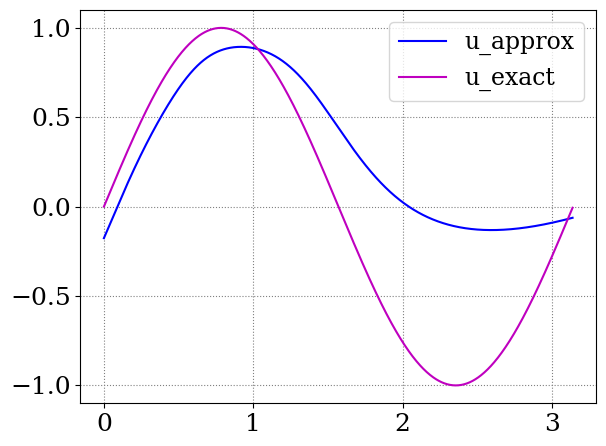

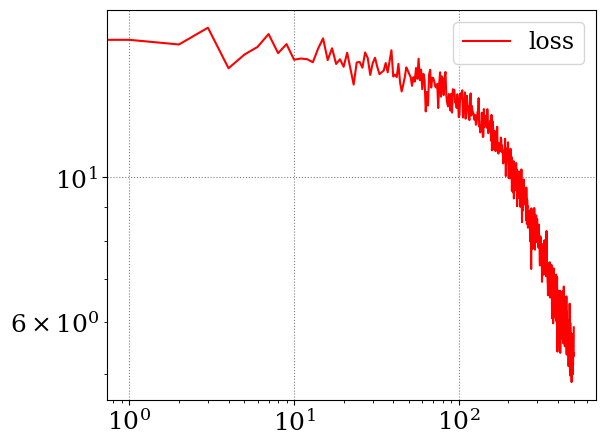

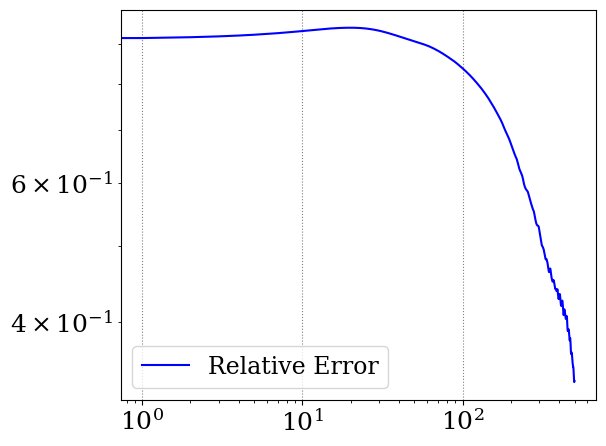

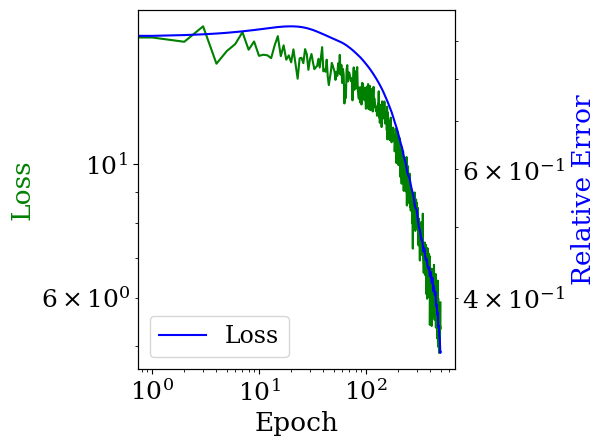

In [ ]:

uModel1 = makeModel1(neurons=neurons, nLayers=nLayers, activation='tanh')
lossModel1 = makeLossModel1(uModel1, nPts, fRhs, lambda0, lambda1, lambda2, limInf, limSup)

optimizer = keras.optimizers.Adam(learning_rate=10**-3)
lossModel1.compile(optimizer=optimizer, loss=trickyLoss)

relative_error_callback = RelativeErrorCallback(uModel1, exactU, nPts)
history1 = lossModel1.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=1, callbacks=[relative_error_callback])

xList = np.array([np.pi / 1000 * i for i in range(1000)])
plotResults(uModel1, history1, exactU, xList, 'Approximation of the solution')

In [58]:
def plotResultsGrid(uModel, history, exactU, xList, title, ax):
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    # Plot u vs u_approx
    ax[0].plot(xList, uModel(xList), color='b')
    ax[0].plot(xList, exactU(xList), color='m')
    ax[0].legend(['u_approx', 'u_exact'])
    ax[0].grid(which='both', axis='both', linestyle=':', color='gray')
    ax[0].set_title(title)

    # Plot loss
    ax[1].plot(history.history['loss'], color='r')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].legend(['loss'])
    ax[1].grid(which='major', axis='both', linestyle=':', color='gray')

    # Plot relative error
    ax[2].plot(history.history['relative_error'], color='b')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].legend(['Relative Error'])
    ax[2].grid(which='major', axis='both', linestyle=':', color='gray')

    # Plot loss vs relative error
    ax1 = ax[3]
    ax2 = ax1.twinx()
    ax1.plot(history.history['loss'], 'g-')
    ax2.plot(history.history['relative_error'], 'b-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='g')
    ax2.set_ylabel('Relative Error', color='b')
    ax1.legend(['Loss'], loc='upper left')
    ax2.legend(['Relative Error'], loc='upper right')
    ax1.grid(which='major', axis='both', linestyle=':', color='gray')

In [63]:
def run_experiments_with_different_fRhs(activation_function):
    functions = [
        {
            'fRhs': lambda x: (alpha + 4) * keras.ops.sin(2 * x),
            'exactU': lambda x: keras.ops.sin(2 * x),
            'title': 'sin(2x)'
        },
        {
            'fRhs': lambda x: 17/4 * keras.ops.sin(2 * x) * keras.ops.cos(x / 2) + 2 * keras.ops.sin(x / 2) * keras.ops.cos(2 * x) + alpha * keras.ops.sin(2 * x) * keras.ops.cos(x / 2),
            'exactU': lambda x: keras.ops.sin(2 * x) * keras.ops.cos(x / 2),
            'title': 'sin(2x) * cos(x/2)'
        },
        {
            'fRhs': lambda x: - 2 * (6 * x**2 - 6 * np.pi * x + np.pi**2) + alpha * (x**2 * (x - np.pi)**2),
            'exactU': lambda x: x**2 * (x - np.pi)**2,
            'title': 'x^2 * (x - pi)^2'
        },
        {
            'fRhs': lambda x: - 6 * (x - 1) + alpha * (x**3 - 3*x**2 + 2*x),
            'exactU': lambda x: x**3 - 3*x**2 + 2*x,
            'title': 'x^3 - 3x^2 + 2x'
        },
        {
            'fRhs': lambda x: - keras.ops.exp(x) + alpha * keras.ops.exp(x),
            'exactU': lambda x: keras.ops.exp(x),
            'title': 'exp(x)'
        },
        {
            'fRhs': lambda x: - keras.ops.sinh(x) + alpha * keras.ops.sinh(x),
            'exactU': lambda x: keras.ops.sinh(x),
            'title': 'sinh(x)'
        },
        {
            'fRhs': lambda x: - ( ( (8 * x**2) / (1 + x**2)**3 ) - ( 2 / (1 + x**2)**2 ) ) + alpha * 1 / (1 + x**2),
            'exactU': lambda x: 1 / (1 + x**2),
            'title': '1 / (1 + x^2)'
        },
    ]

    results = []

    fig, axs = plt.subplots(len(functions), 4, figsize=(20, 5 * len(functions)))

    for i, func in enumerate(functions):
        fRhs = func['fRhs']
        exactU = func['exactU']
        title = func['title']

        uModel1 = makeModel1(neurons=neurons, nLayers=nLayers, activation=activation_function)
        lossModel1 = makeLossModel1(uModel1, nPts, fRhs, lambda0, lambda1, lambda2, limInf, limSup)
        optimizer = keras.optimizers.Adam(learning_rate=10**-3)
        lossModel1.compile(optimizer=optimizer, loss=trickyLoss)

        relative_error_callback = RelativeErrorCallback(uModel1, exactU, nPts)
        history1 = lossModel1.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=0, callbacks=[relative_error_callback])

        final_loss = history1.history['loss'][-1]
        final_relative_error = history1.history['relative_error'][-1].numpy()  # Convert tensor to numpy

        results.append({
            'title': title,
            'final_loss': final_loss,
            'final_relative_error': final_relative_error,
        })

        xList = np.array([np.pi / 1000 * i for i in range(1000)])
        plotResultsGrid(uModel1, history1, exactU, xList, title, axs[i])

    df_results = pd.DataFrame(results)
    print(df_results.to_string(index=False))  # Print DataFrame without index
    plt.tight_layout()
    plt.show()

             title  final_loss  final_relative_error
           sin(2x)    5.794335              0.320486
sin(2x) * cos(x/2)    2.226828              0.124942
  x^2 * (x - pi)^2  101.175056              0.501576
   x^3 - 3x^2 + 2x   47.617226              0.727788
            exp(x)   90.231041              0.883478
           sinh(x)   17.906847              0.789160
     1 / (1 + x^2)    0.064118              0.832653


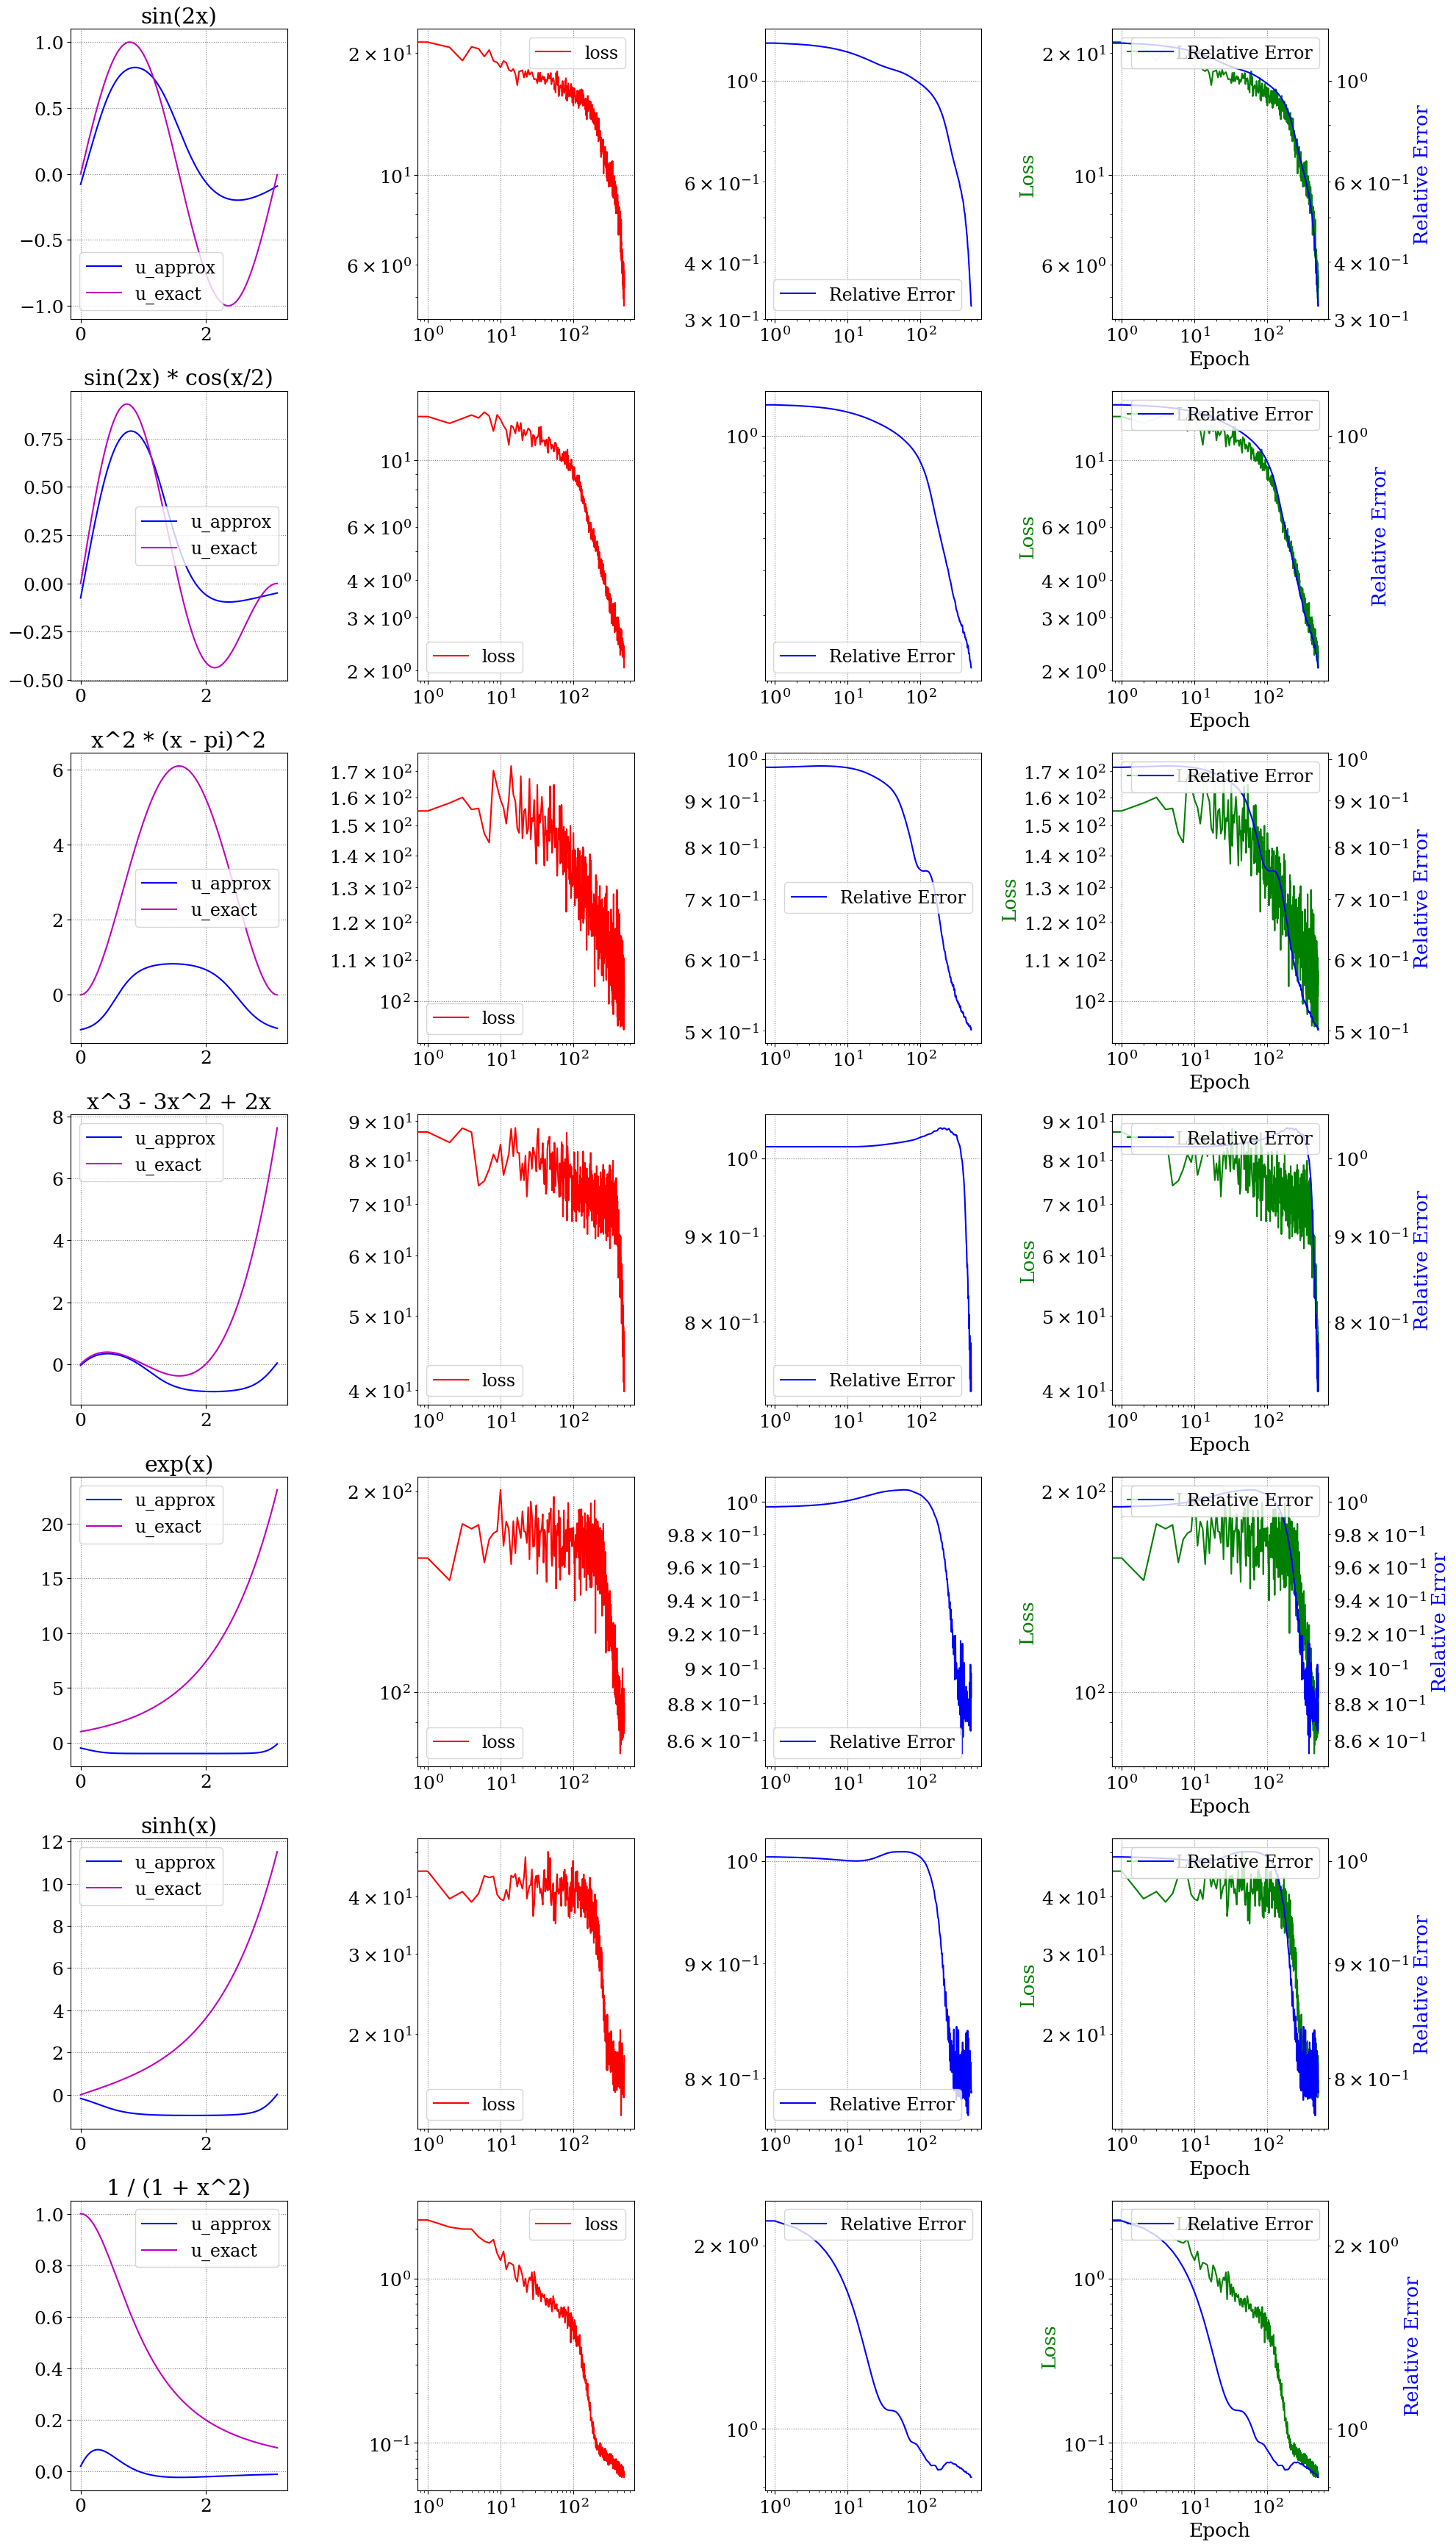

In [64]:
# Ejecutar los experimentos con diferentes fRhs
run_experiments_with_different_fRhs('tanh')

             title  final_loss  final_relative_error
           sin(2x)    2.247978              0.176964
sin(2x) * cos(x/2)    2.029317              0.101329
  x^2 * (x - pi)^2   10.660543              0.017641
   x^3 - 3x^2 + 2x   38.942944              0.715102
            exp(x)   85.823730              0.831127
           sinh(x)   16.806578              0.807615
     1 / (1 + x^2)    0.005475              0.672783


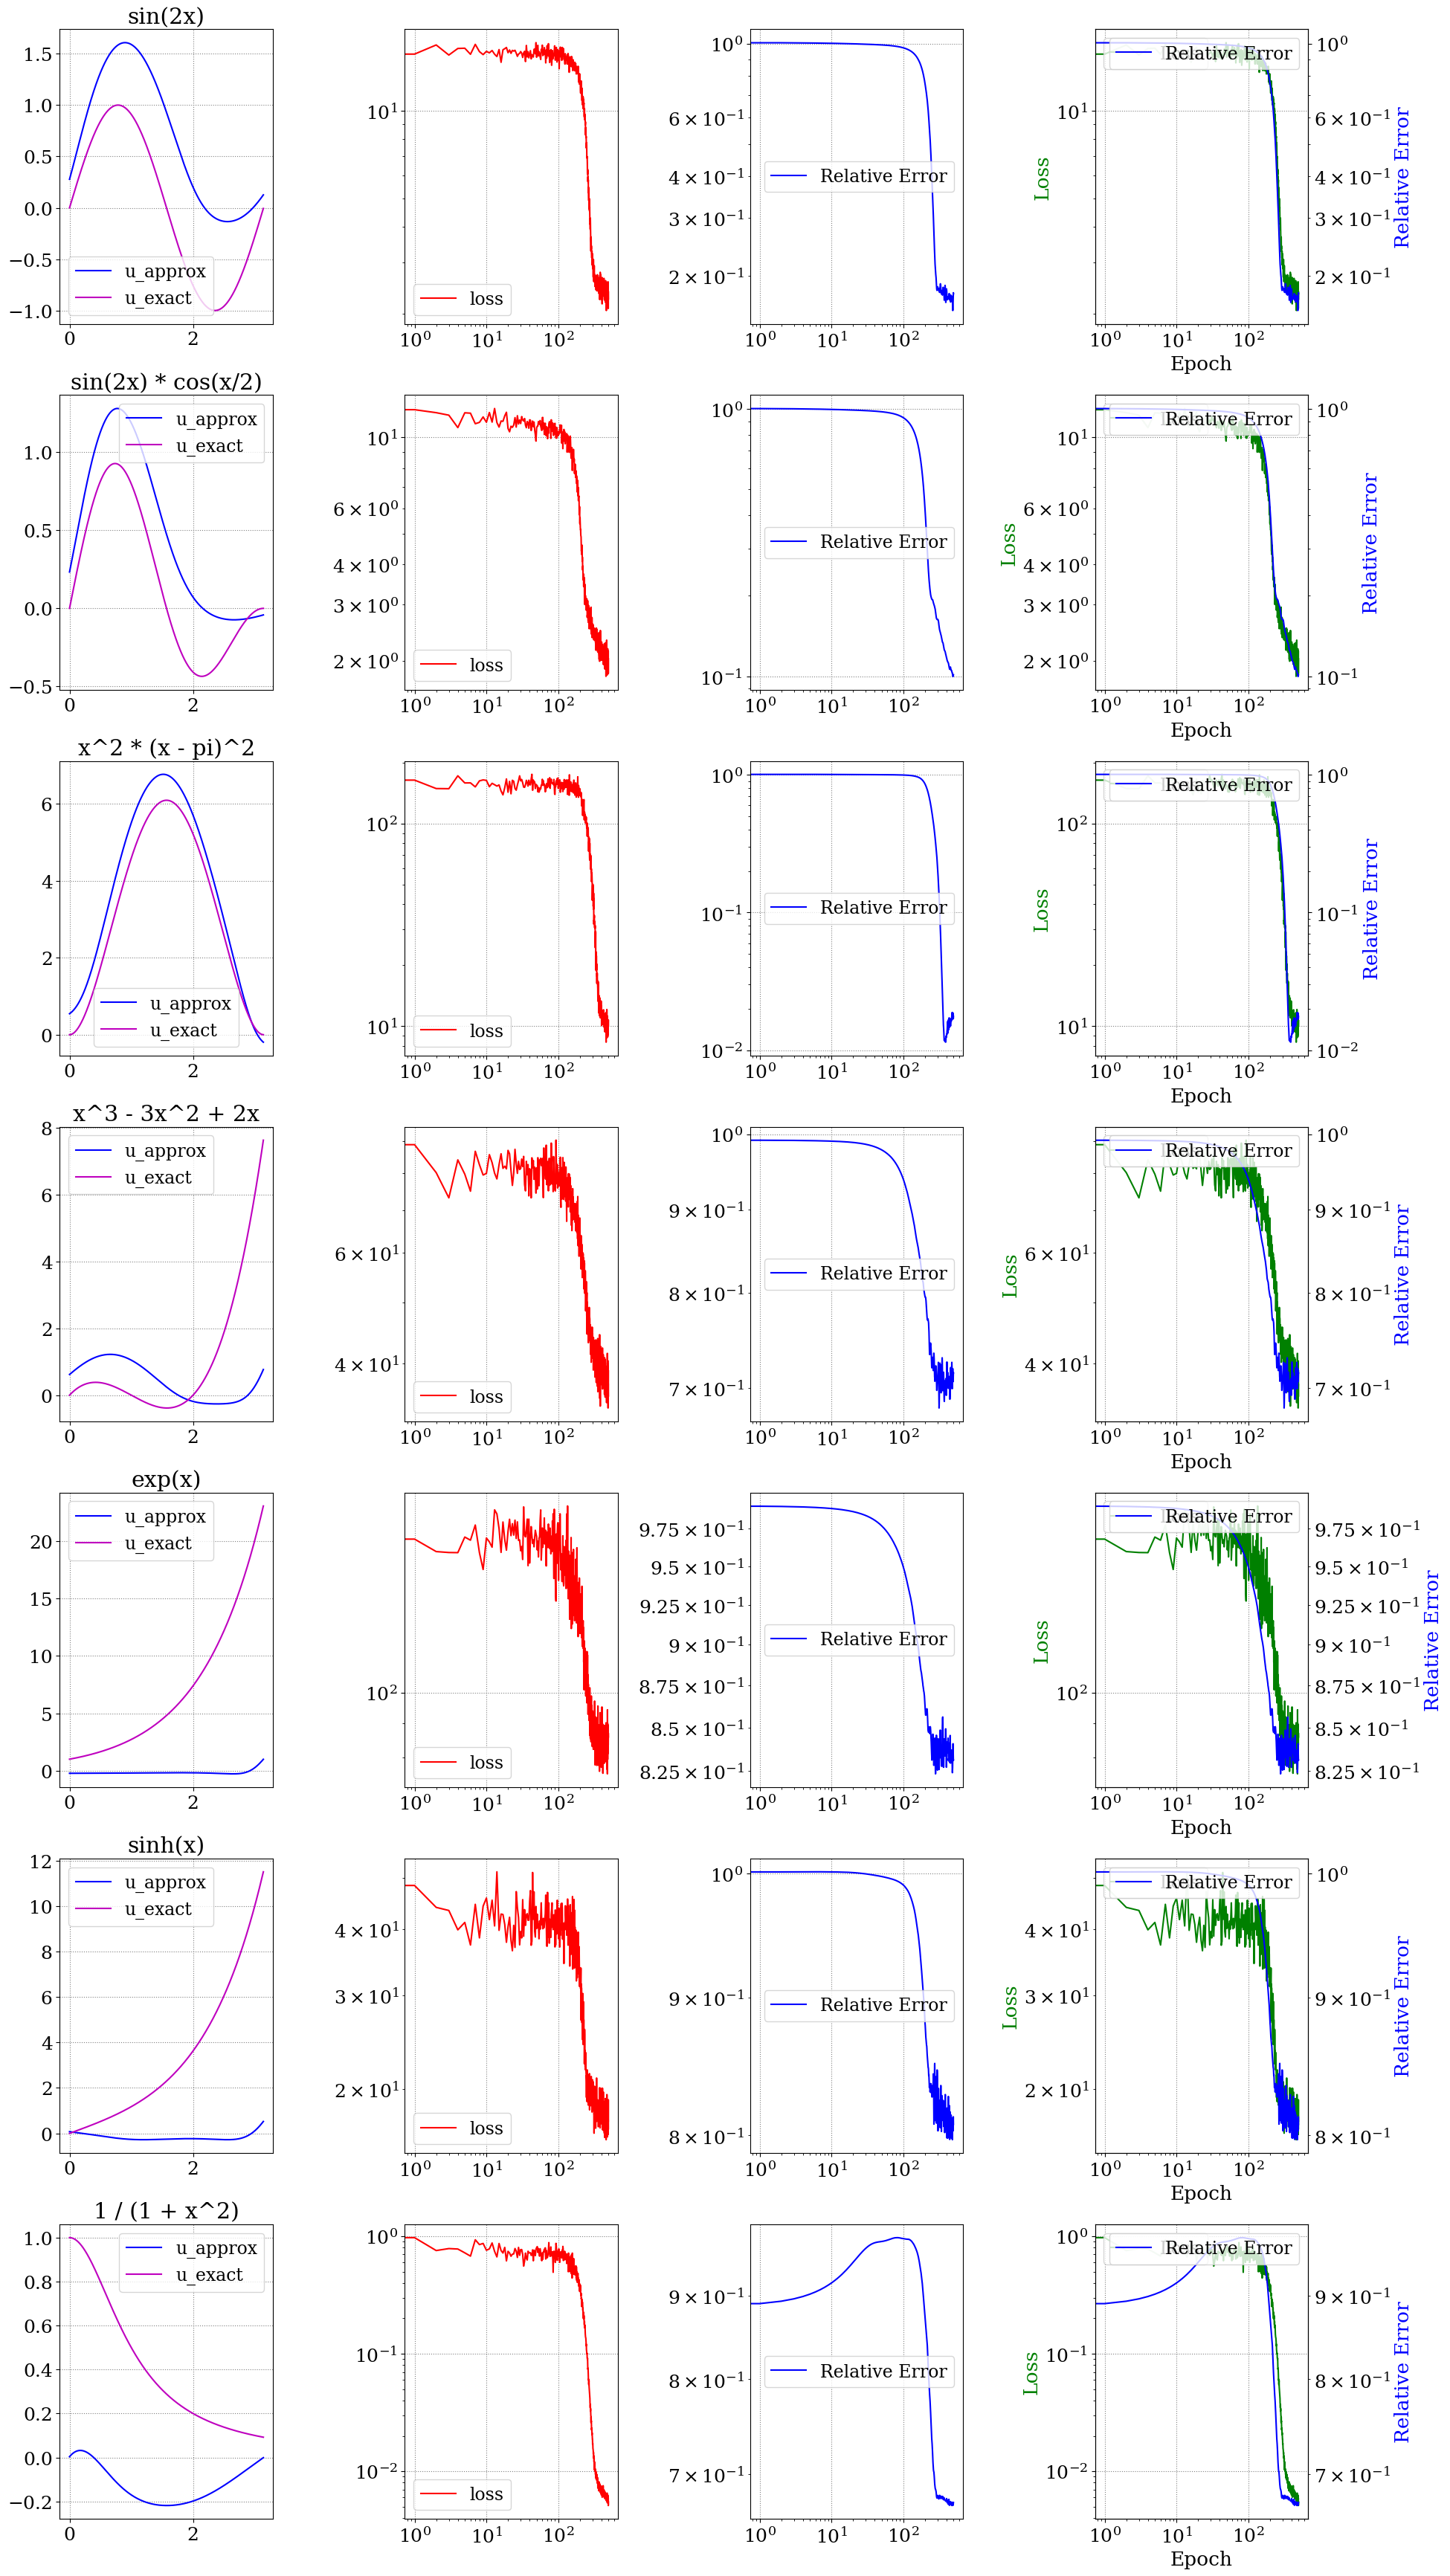

In [66]:
run_experiments_with_different_fRhs('swish')

             title  final_loss  final_relative_error
           sin(2x)   15.776278              0.995296
sin(2x) * cos(x/2)   10.810403              0.986393
  x^2 * (x - pi)^2  149.365723              1.007915
   x^3 - 3x^2 + 2x   77.772835              1.123066
            exp(x)  157.123306              1.002022
           sinh(x)   40.307003              0.998319
     1 / (1 + x^2)    0.140530              0.673475


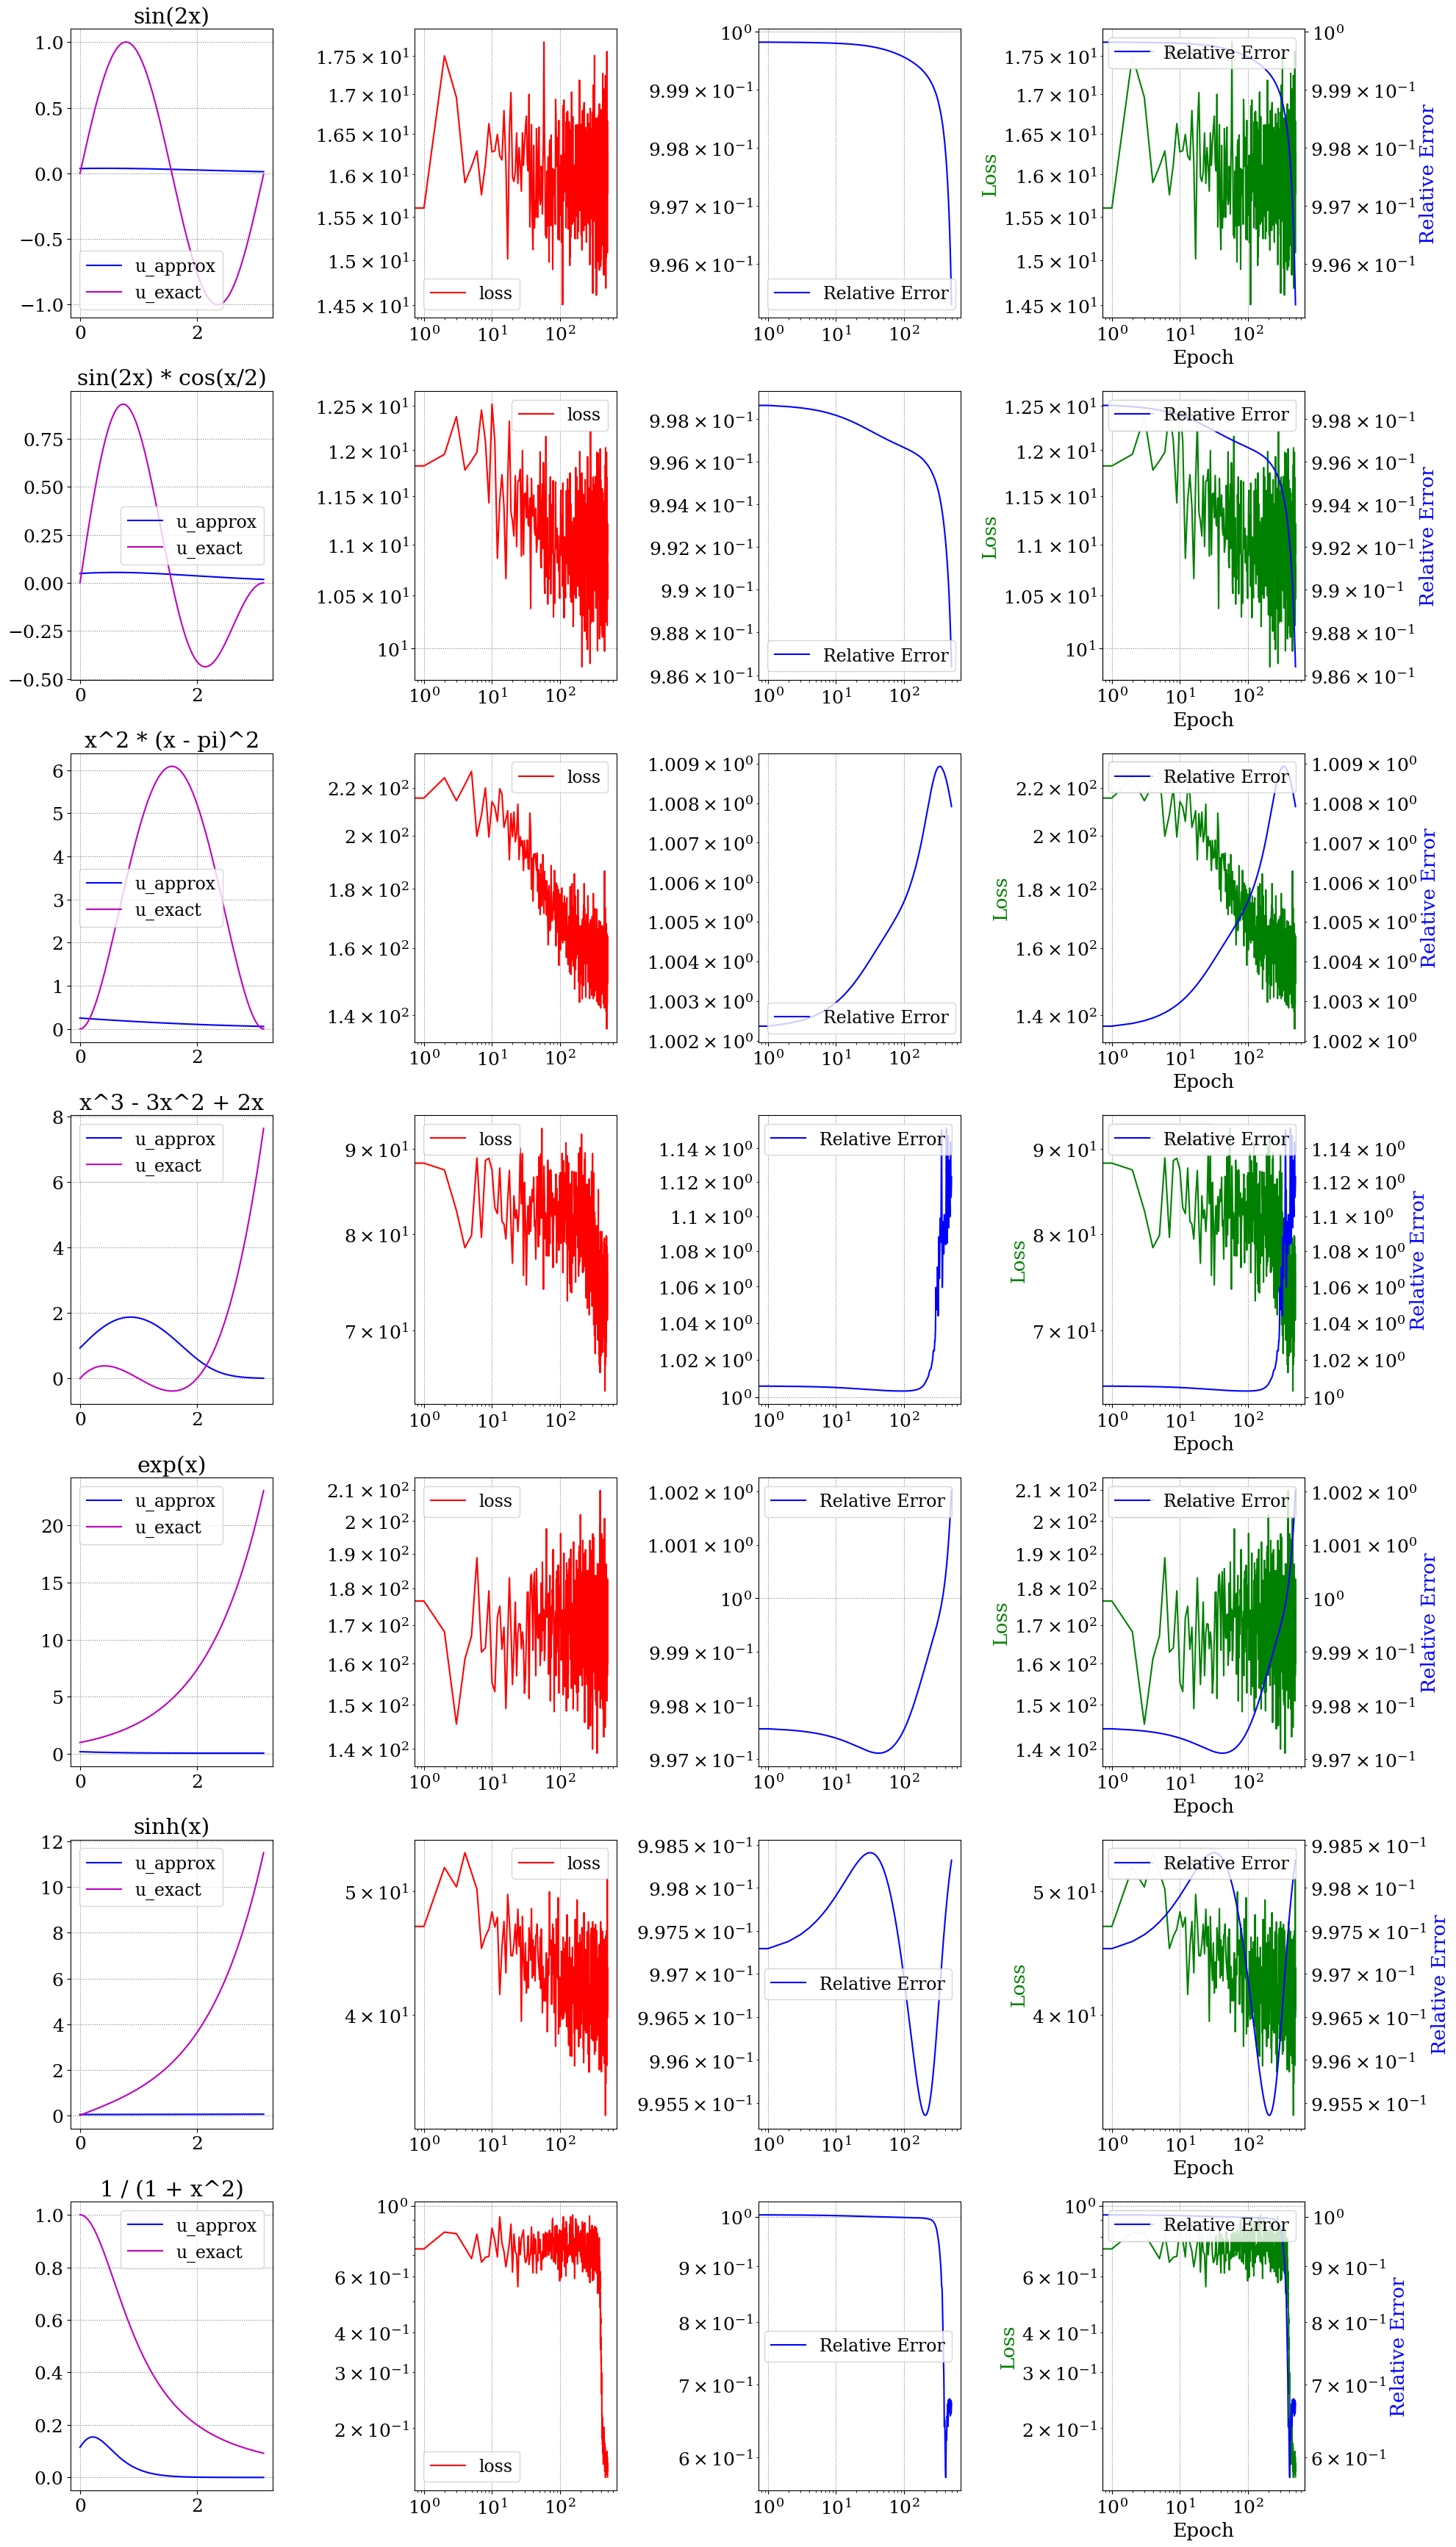

In [67]:
run_experiments_with_different_fRhs('softplus')